Word embedding -> 2 dimension -> 5 features

In [15]:
import torch
from torch import nn
from torch.nn import functional as F

from typing import Optional

from dataclasses import dataclass, replace
import numpy as np
import einops

from tqdm.notebook import trange

import time
import pandas as pd
import os

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt

import nltk
import csv
from nltk.corpus import words

from trainer import BaseTrainer
from model import Config, Model
from dm import DataManager

In [16]:
if torch.cuda.is_available():
  DEVICE = 'cuda'
elif torch.backends.mps.is_available():
  DEVICE = 'mps'
else:
  DEVICE = 'cpu'

In [9]:
# Download the words corpus if not already downloaded
nltk.download('words', quiet=True)

# Get the list of English words
english_words = words.words()

# Define prefixes and suffixes
prefixes = ['un', 'anti', 'inter']
suffixes = ['able', 'less']

# Function to categorize a word
def categorize_word(word):
    prefix_match = next((prefix for prefix in prefixes if word.startswith(prefix)), None)
    suffix_match = next((suffix for suffix in suffixes if word.endswith(suffix)), None)
    
    if prefix_match and suffix_match:
        return 'dual'
    elif prefix_match:
        return prefix_match
    elif suffix_match:
        return suffix_match
    else:
        return None

# Process words and create dataset
dataset = []
for word in english_words:
    category = categorize_word(word)
    if category:
        dataset.append([word, category])

# Save to CSV
with open('word_affixes_dataset.csv', 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(['word', 'category'])  # Header
    writer.writerows(dataset)

print(f"Dataset created with {len(dataset)} words.")

Dataset created with 20900 words.


In [10]:
dm = DataManager()
dm.read_csv_data('word_affixes_dataset.csv')
dm.manipulate_data()
dm.train_valid_test_split()


Sample words and corresponding categories (non-dual)... 

['abandonable', 'abashless', 'abatable', 'abdicable', 'abhominable']
['able', 'less', 'able', 'able', 'able']

Sample dual words...

['anticipatable', 'antiportable', 'interavailable', 'interchangeable', 'intercommonable']


In [11]:
for x, y in dm.train_loader:
    print(x.shape, y.shape)
    break

torch.Size([64, 8]) torch.Size([64])


In [12]:
config = Config(
    vocab_size=dm.vocab_size,
    word2idx=dm.word2idx,
    n_features=dm.num_classes,
    n_hidden=2,
)

model = Model(config)

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
trainer = BaseTrainer(model=model, criterion=criterion, optimizer=optimizer, train_loader=dm.train_loader, val_loader=dm.valid_loader, device=DEVICE)
trainer.fit(num_epochs=200)

Epoch 1/200
247/247 - train_loss: 1.0103 - train_accuracy: 58.9672%
Epoch 2/200
247/247 - train_loss: 0.4727 - train_accuracy: 78.6356%
Epoch 3/200
247/247 - train_loss: 0.3785 - train_accuracy: 81.5087%
Epoch 4/200
247/247 - train_loss: 0.3444 - train_accuracy: 84.0969%
Epoch 5/200
247/247 - train_loss: 0.3236 - train_accuracy: 84.6349%
Epoch 6/200
247/247 - train_loss: 0.2982 - train_accuracy: 85.4196%
Epoch 7/200
247/247 - train_loss: 0.2888 - train_accuracy: 86.3372%
Epoch 8/200
247/247 - train_loss: 0.2770 - train_accuracy: 86.6346%
Epoch 9/200
247/247 - train_loss: 0.2734 - train_accuracy: 86.9067%
Epoch 10/200
247/247 - train_loss: 0.2590 - train_accuracy: 87.7231%
Epoch 11/200
247/247 - train_loss: 0.2611 - train_accuracy: 87.3244%
Epoch 12/200
247/247 - train_loss: 0.2541 - train_accuracy: 87.7674%
Epoch 13/200
247/247 - train_loss: 0.2502 - train_accuracy: 87.9066%
Epoch 14/200
247/247 - train_loss: 0.2490 - train_accuracy: 88.0015%
Epoch 15/200
247/247 - train_loss: 0.2498 -

In [17]:
if not os.path.exists("checkpoints"):
    os.makedirs("checkpoints")
torch.save(model.state_dict(), "checkpoints/unantiinterableless.pth")

In [34]:
def plot_intro_diagram(model, hiddens=None):
  from matplotlib import colors  as mcolors
  from matplotlib import collections  as mc
  cfg = model.config
  W = model.W.cpu().detach()
  N = len(W[:,0])
  sel = range(1)
  # plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.viridis(model.importance[0].cpu().numpy()))
  plt.rcParams['figure.dpi'] = 200
  fig, ax = plt.subplots(1,len(sel), figsize=(2*len(sel),2))
  colors = [mcolors.to_rgba(c)
        for c in plt.rcParams['axes.prop_cycle'].by_key()['color']]
  ax.scatter(W[:,0], W[:,1], c=colors[0:len(W[:,0])])
  ax.set_aspect('equal')
  ax.add_collection(mc.LineCollection(np.stack((np.zeros_like(W),W), axis=1), colors=colors))

  if hiddens is not None:
    activation = hiddens.cpu().detach().numpy()
    ax.scatter(activation[0, 0], activation[0, 1], c='black', s=100)
    
    ax.add_collection(mc.LineCollection([[(0, 0), (activation[0, 0], activation[0, 1])]], 
                                        colors=['black'], 
                                        linewidths=2, 
                                        linestyle='--'))

  z = 20
  ax.set_facecolor('#FCFBF8')
  ax.set_xlim((-z,z))
  ax.set_ylim((-z,z))
  ax.tick_params(left = True, right = False , labelleft = False ,
              labelbottom = False, bottom = True)
  for spine in ['top', 'right']:
      ax.spines[spine].set_visible(False)
  for spine in ['bottom','left']:
      ax.spines[spine].set_position('center')
  plt.show()

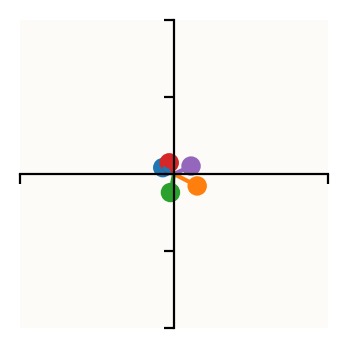

In [35]:
plot_intro_diagram(model)

In [36]:
def get_activation_from_word(word):
    tokens = dm.tokenize_data(word).to(DEVICE)
    outputs, hidden = model.forward(tokens.unsqueeze(0), return_hidden=True)
    _, predicted = torch.max(outputs.data, 1)
    return predicted, hidden

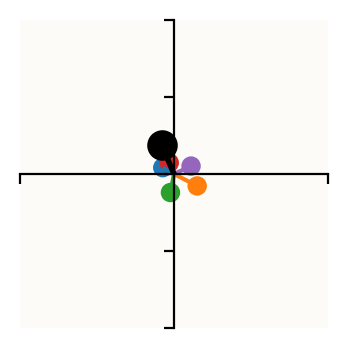

actual: un, predicted: less


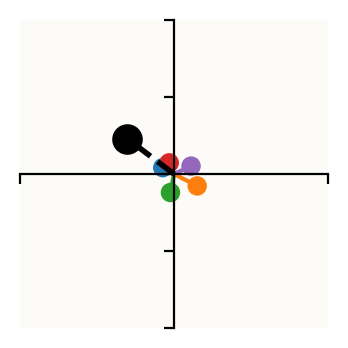

actual: anti, predicted: able


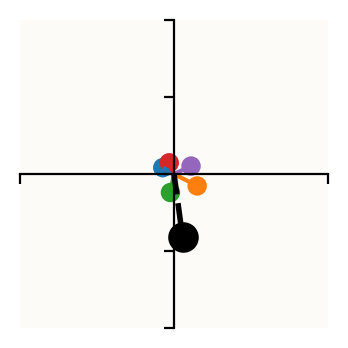

actual: inter, predicted: inter


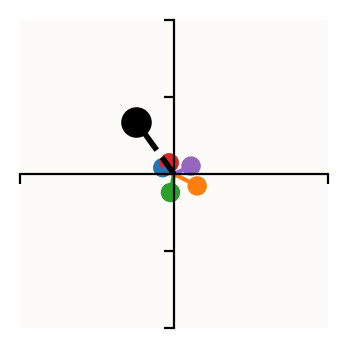

actual: able, predicted: less


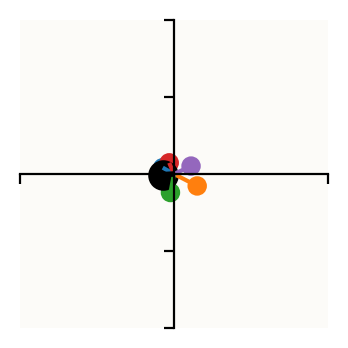

actual: less, predicted: inter


In [37]:
for affix in (prefixes + suffixes):
    out, acts = get_activation_from_word(affix)
    plot_intro_diagram(model, acts)
    print(f"actual: {affix}, predicted: {dm.str_classes[out]}")

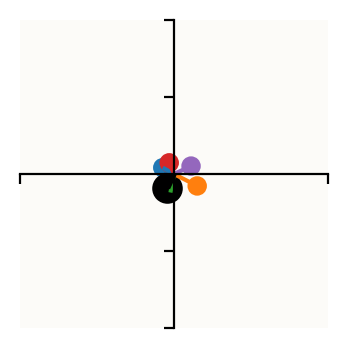

inter


In [39]:
out, acts = get_activation_from_word("interpretable")
plot_intro_diagram(model, acts)
print(dm.str_classes[out])

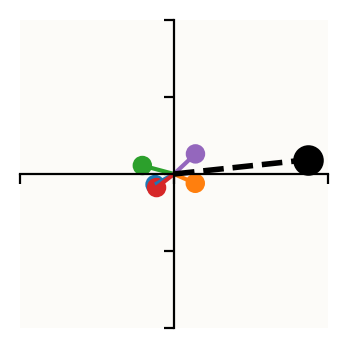

un


In [71]:
out, acts = get_activation_from_word("un")
plot_intro_diagram(model, acts)
print(dm.str_classes[out])

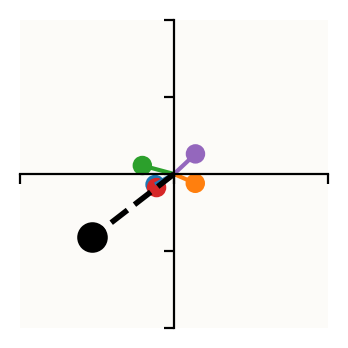

ing


In [76]:
out, acts = get_activation_from_word("pre")
plot_intro_diagram(model, acts)
print(dm.str_classes[out])

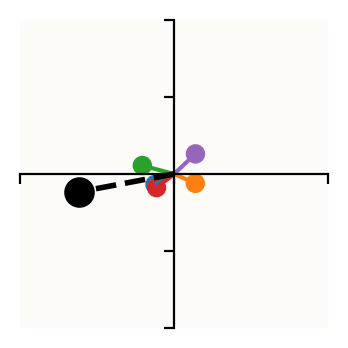

re


In [73]:
out, acts = get_activation_from_word("re")
plot_intro_diagram(model, acts)
print(dm.str_classes[out])

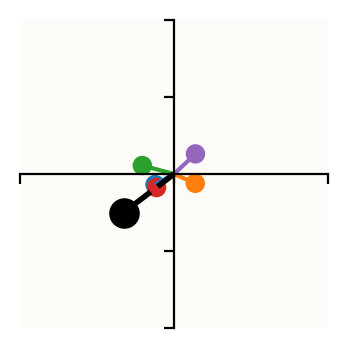

ing


In [74]:
out, acts = get_activation_from_word("ing")
plot_intro_diagram(model, acts)
print(dm.str_classes[out])

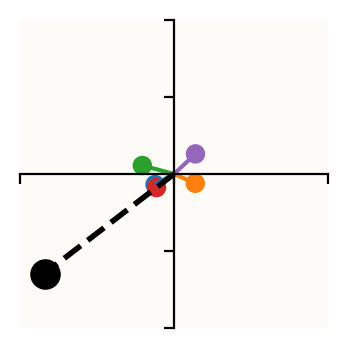

tion


In [75]:
out, acts = get_activation_from_word("tion")
plot_intro_diagram(model, acts)
print(dm.str_classes[out])

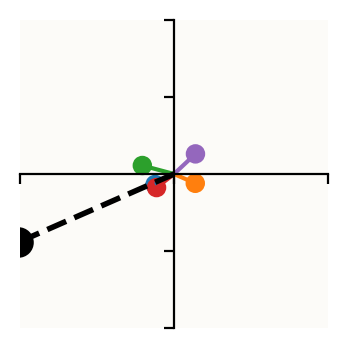

re


In [59]:
out, acts = get_activation_from_word("reinvent")
plot_intro_diagram(model, acts)
print(dm.str_classes[out])

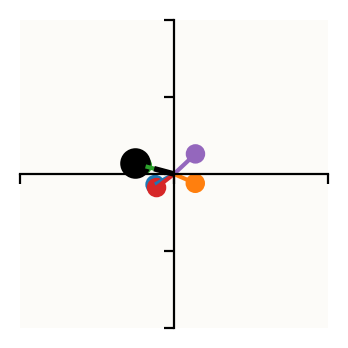

re


In [60]:
out, acts = get_activation_from_word("redo")
plot_intro_diagram(model, acts)
print(dm.str_classes[out])

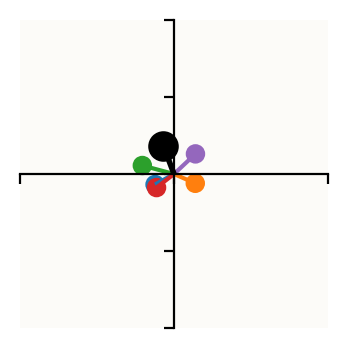

re


In [61]:
out, acts = get_activation_from_word("respond")
plot_intro_diagram(model, acts)
print(dm.str_classes[out])

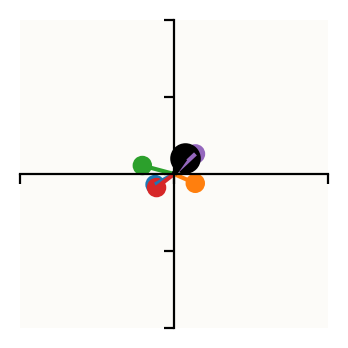

ing


In [62]:
out, acts = get_activation_from_word("replicate")
plot_intro_diagram(model, acts)
print(dm.str_classes[out])

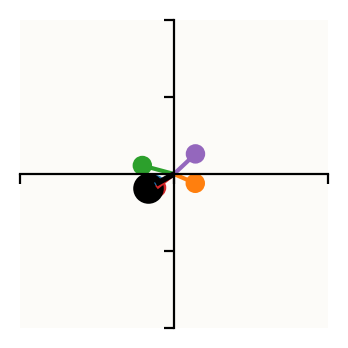

ing


In [63]:
out, acts = get_activation_from_word("something")
plot_intro_diagram(model, acts)
print(dm.str_classes[out])

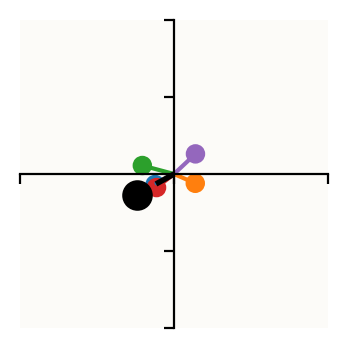

ing


In [64]:
out, acts = get_activation_from_word("anything")
plot_intro_diagram(model, acts)
print(dm.str_classes[out])

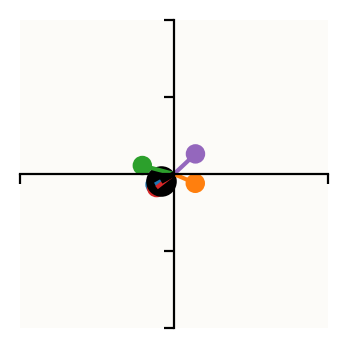

ing


In [65]:
out, acts = get_activation_from_word("doing")
plot_intro_diagram(model, acts)
print(dm.str_classes[out])

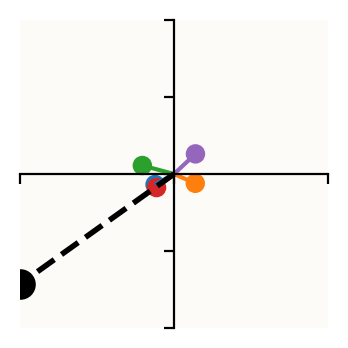

tion


In [66]:
out, acts = get_activation_from_word("lactation")
plot_intro_diagram(model, acts)
print(dm.str_classes[out])

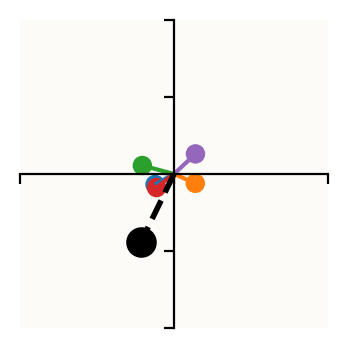

tion


In [67]:
out, acts = get_activation_from_word("nation")
plot_intro_diagram(model, acts)
print(dm.str_classes[out])

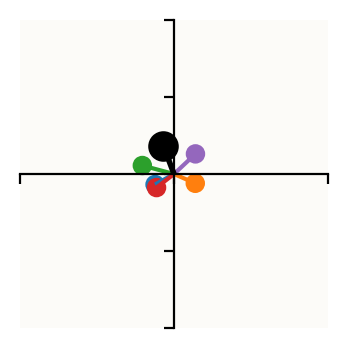

re


In [68]:
out, acts = get_activation_from_word("respond")
plot_intro_diagram(model, acts)
print(dm.str_classes[out])

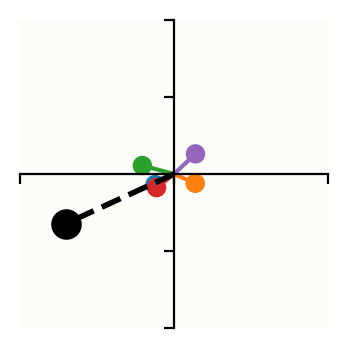

re


In [69]:
out, acts = get_activation_from_word("replay")
plot_intro_diagram(model, acts)
print(dm.str_classes[out])

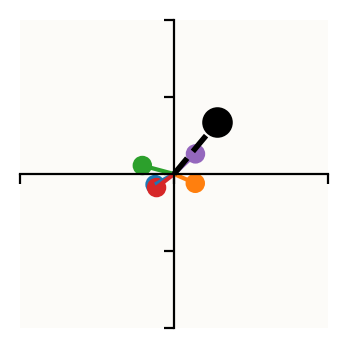

un


In [70]:
out, acts = get_activation_from_word("uncanny")
plot_intro_diagram(model, acts)
print(dm.str_classes[out])

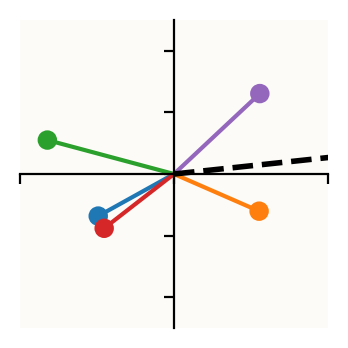

un


In [25]:
out, acts = get_activation_from_word("un")
plot_intro_diagram(model, acts)
print(dm.str_classes[out])

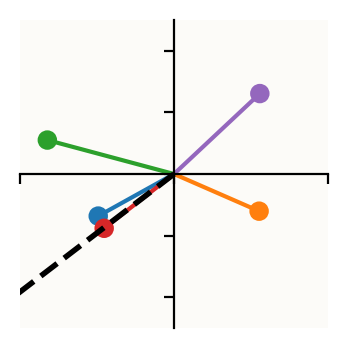

ing


In [26]:
out, acts = get_activation_from_word("ing")
plot_intro_diagram(model, acts)
print(dm.str_classes[out])

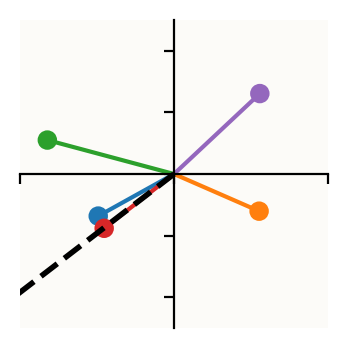

tion


In [27]:
out, acts = get_activation_from_word("tion")
plot_intro_diagram(model, acts)
print(dm.str_classes[out])